<a href="https://colab.research.google.com/github/bogdnnx/prikoli1/blob/master/MOVR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Анализ временного ряда криптовалют **

# 1) **Для начала подготовим все необходимые либы для успешного и удобного выполнения прокта без изобретения велосипеда **


In [95]:
!pip install yfinance statsmodels matplotlib pandas pmdarima
!pip install pycoingecko

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.signal import detrend
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from pycoingecko import CoinGeckoAPI


**Загрузка временного ряда** Для того чтобы проанализировать какую-либо монету необходимо ввести её тикер, например: BTC, ETH, DOGE и тд.



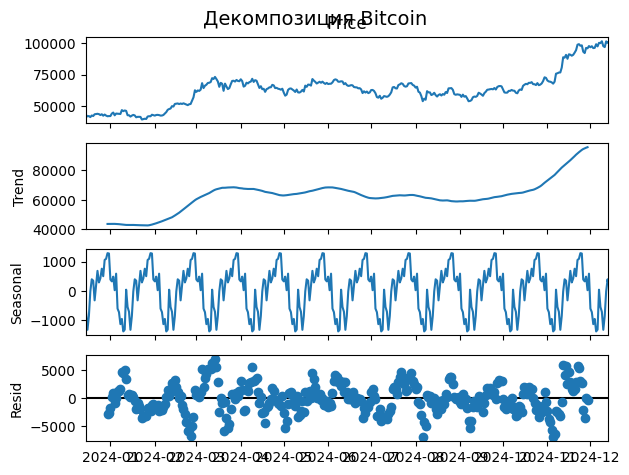

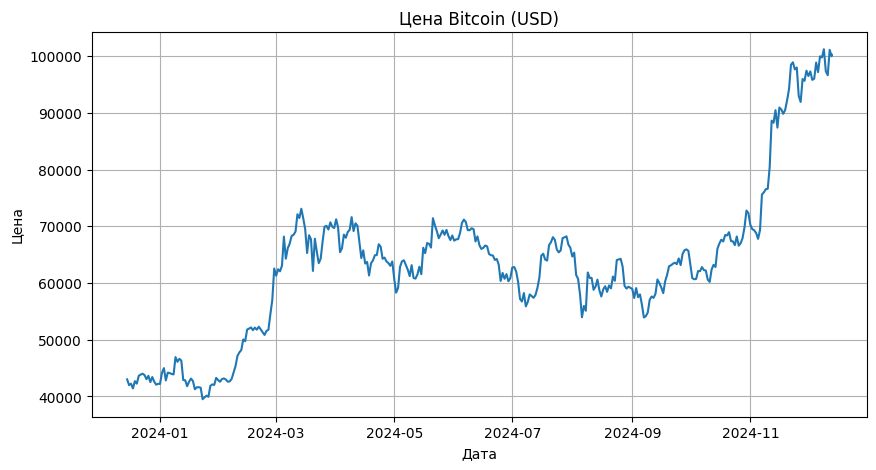

In [107]:
cg = CoinGeckoAPI()
coin_id = 'bitcoin'  # Например, выберем биткойн
coin_data = cg.get_coin_market_chart_by_id(id=coin_id, vs_currency='usd', days=365)

# Преобразуем данные в DataFrame
df = pd.DataFrame(coin_data['prices'], columns=['Date', 'Price'])
df['Date'] = pd.to_datetime(df['Date'], unit='ms')
df.set_index('Date', inplace=True)

# Декомпозиция ряда (сезонность, тренд, остатки)
result = seasonal_decompose(df['Price'], model='additive', period=30)
result.plot()
plt.suptitle(f'Декомпозиция {coin_id.capitalize()}', fontsize=14)
plt.show()

# Строим график исходного ряда
plt.figure(figsize=(10, 5))
plt.plot(df['Price'])
plt.title(f'Цена {coin_id.capitalize()} (USD)')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.grid(True)
plt.show()

# Строим график разностей
df['Price_diff1'] = df['Price'].diff().dropna()  # Первая разность
df['Price_diff2'] = df['Price_diff1'].diff().dropna()  # Вторая разность







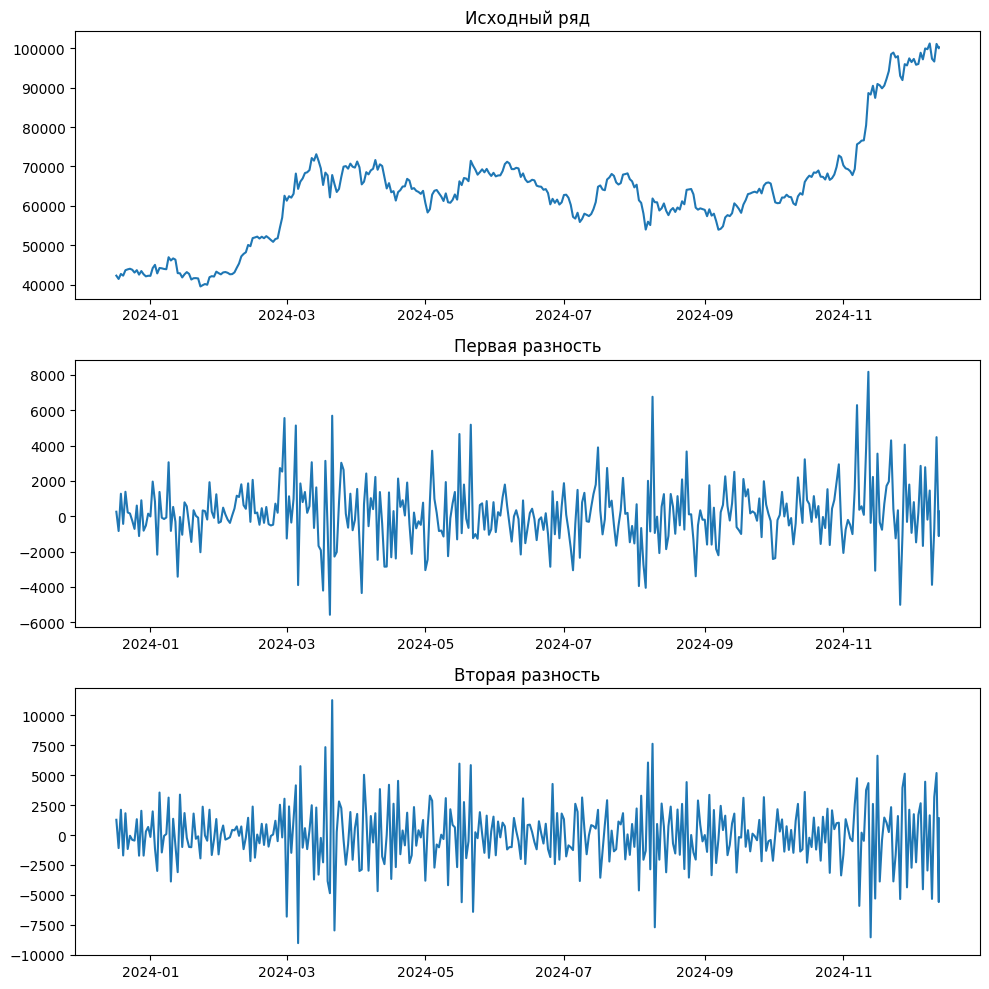

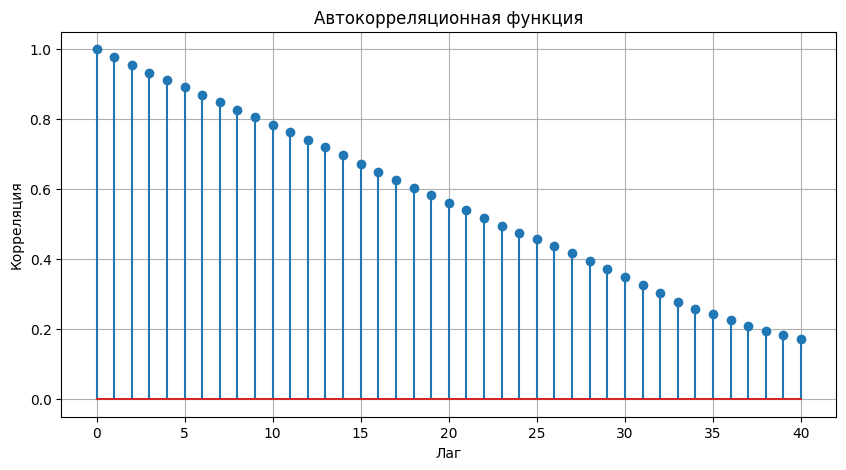

In [109]:
# Убираем пустые значения
df = df.dropna()

# Графики разностей
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
axes[0].plot(df['Price'], label='Исходный ряд')
axes[0].set_title('Исходный ряд')
axes[1].plot(df['Price_diff1'], label='Первая разность')
axes[1].set_title('Первая разность')
axes[2].plot(df['Price_diff2'], label='Вторая разность')
axes[2].set_title('Вторая разность')
plt.tight_layout()
plt.show()

acf_values = acf(df['Price'].dropna(), nlags=40)
plt.figure(figsize=(10, 5))
# Remove use_line_collection or update matplotlib
# plt.stem(acf_values, use_line_collection=True)
plt.stem(acf_values) # if using older matplotlib version
plt.title('Автокорреляционная функция')
plt.xlabel('Лаг')
plt.ylabel('Корреляция')
plt.grid(True)
plt.show()

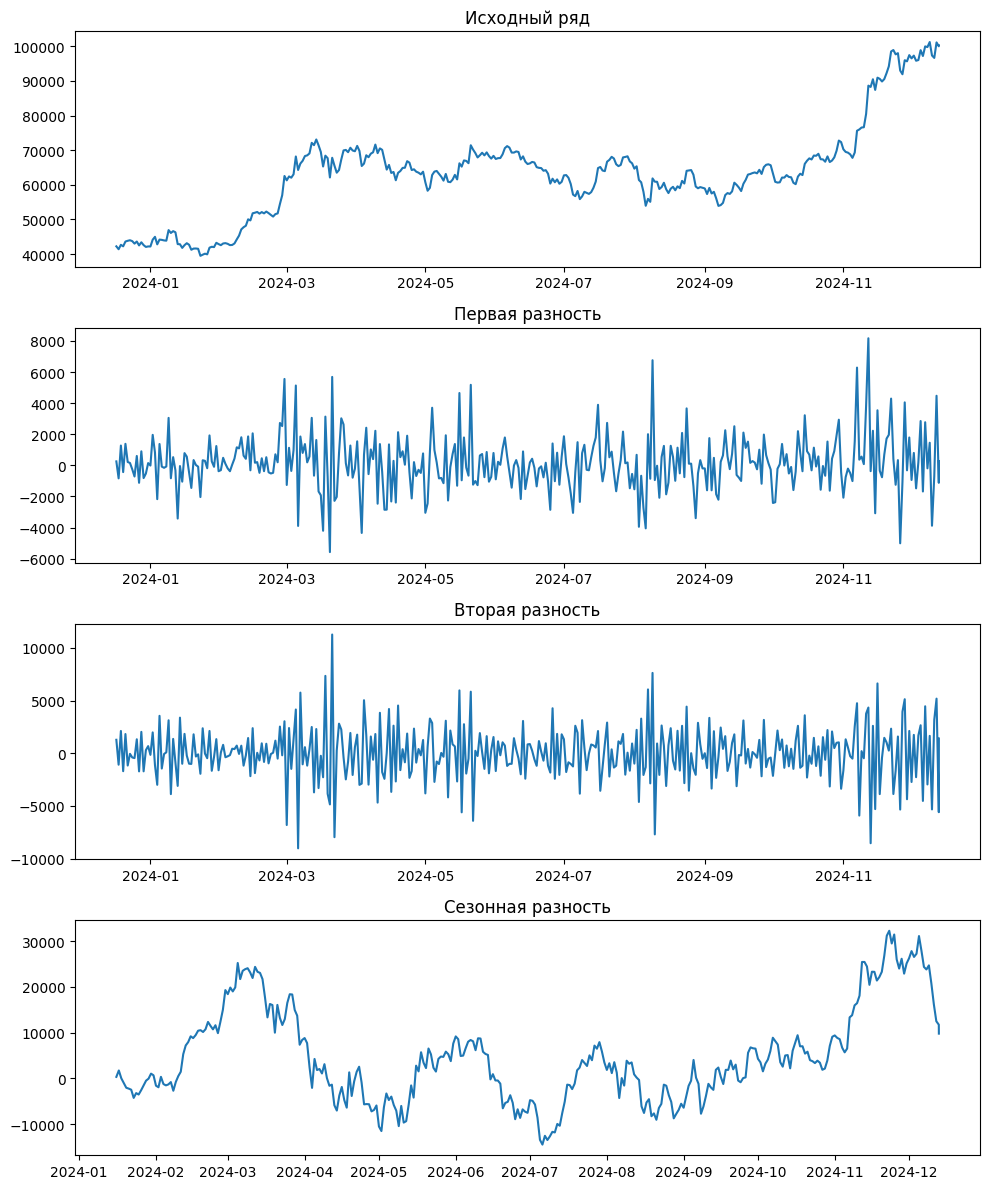

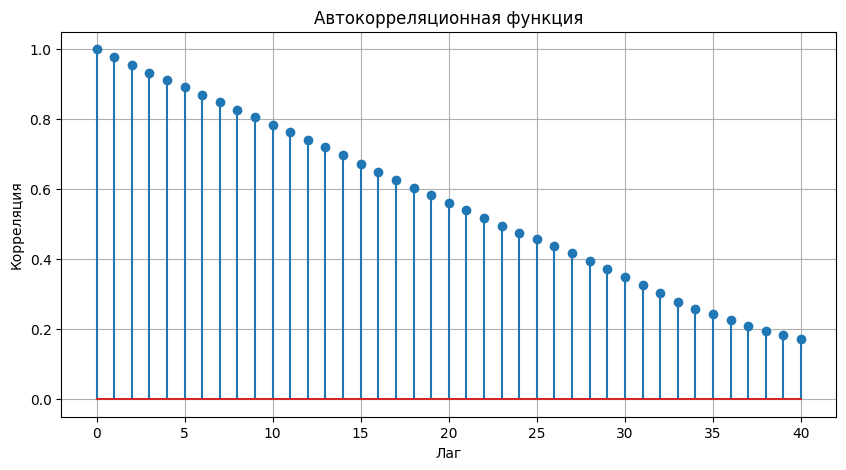

In [110]:
# Убираем пустые значения
df = df.dropna()

# Графики разностей
fig, axes = plt.subplots(4, 1, figsize=(10, 12)) # Increased figure size to accommodate the new plot
axes[0].plot(df['Price'], label='Исходный ряд')
axes[0].set_title('Исходный ряд')
axes[1].plot(df['Price_diff1'], label='Первая разность')
axes[1].set_title('Первая разность')
axes[2].plot(df['Price_diff2'], label='Вторая разность')
axes[2].set_title('Вторая разность')

# Calculate and plot seasonal differences (period=30)
df['Price_diff_seasonal'] = df['Price'].diff(30).dropna() # Seasonal differencing
axes[3].plot(df['Price_diff_seasonal'], label='Сезонная разность')
axes[3].set_title('Сезонная разность') # Title for seasonal differences plot

plt.tight_layout()
plt.show()

# Автокорреляционная функция
acf_values = acf(df['Price'].dropna(), nlags=40)
plt.figure(figsize=(10, 5))
# Remove use_line_collection or update matplotlib
# plt.stem(acf_values, use_line_collection=True)
plt.stem(acf_values) # if using older matplotlib version
plt.title('Автокорреляционная функция')
plt.xlabel('Лаг')
plt.ylabel('Корреляция')
plt.grid(True)
plt.show()

In [111]:
def check_stationarity(series):
    result = adfuller(series)
    return result[1] < 0.05

# Проверка стационарности исходного ряда
is_stationary = check_stationarity(df['Price'])

# Проверка после первой разности
if not is_stationary:
    df['Price_diff1'] = df['Price'].diff().dropna()
    df = df.dropna()  # Убираем пустые значения после разности
    is_stationary = check_stationarity(df['Price_diff1'])

# Проверка после второй разности
if not is_stationary:
    df['Price_diff2'] = df['Price_diff1'].diff().dropna()
    df = df.dropna()  # Убираем пустые значения после разности
    is_stationary = check_stationarity(df['Price_diff2'])

# Преобразование Бокса-Кокса, если ряд не стационарен
if not is_stationary:
    from scipy.stats import boxcox
    df['Price_BoxCox'], lam = boxcox(df['Price'].dropna())
    df = df.dropna()  # Убираем пустые значения после преобразования
    is_stationary = check_stationarity(df['Price_BoxCox'])
    if not is_stationary:
        df['Price_BoxCox_diff1'] = df['Price_BoxCox'].diff().dropna()
        df = df.dropna()  # Убираем пустые значения после разности
        is_stationary = check_stationarity(df['Price_BoxCox_diff1'])

print(f"Стационарен ли ряд после обработки: {is_stationary}")

Стационарен ли ряд после обработки: True


In [112]:
if not is_stationary:
    df['Price_BoxCox'], lam = boxcox(df['Price'].dropna())
    df = df.dropna()  # Убираем пустые значения после преобразования
    print(f"Параметр лямбда для Бокса-Кокса: {lam}")
    plt.figure(figsize=(10, 5))
    plt.plot(df['Price_BoxCox'])
    plt.title(f'Преобразованный ряд Бокса-Кокса')
    plt.grid(True)
    plt.show()

In [113]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Выводим размеры выборок
print(f"Размер обучающей выборки: {train.shape[0]}")
print(f"Размер тестовой выборки: {test.shape[0]}")

Размер обучающей выборки: 267
Размер тестовой выборки: 67


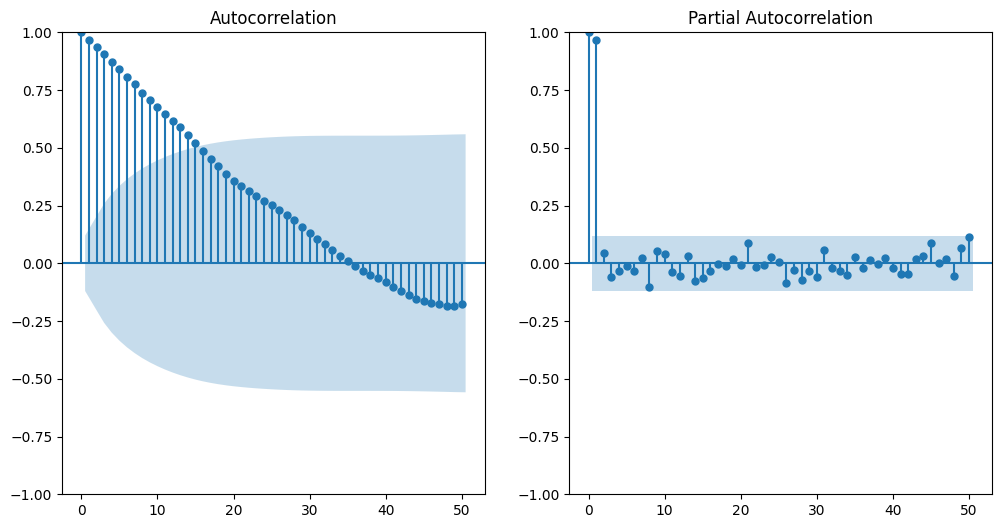

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


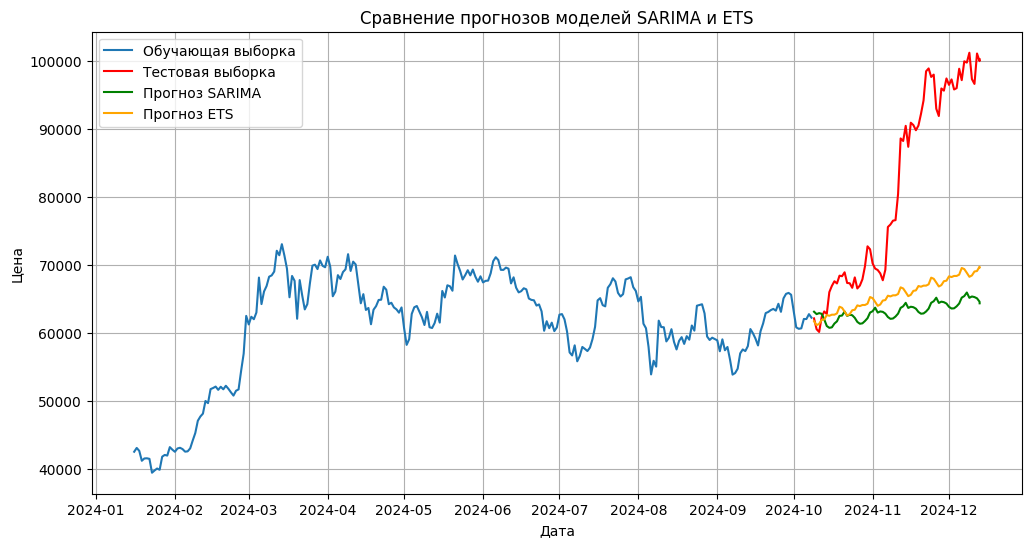

In [122]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Разделение на обучающую и тестовую выборки
train_size = int(len(df) * 0.8)
train, test = df['Price'][:train_size], df['Price'][train_size:]

# Строим ACF и PACF для анализа данных
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(train, lags=50, ax=plt.gca())

plt.subplot(122)
plot_pacf(train, lags=50, ax=plt.gca())

plt.show()

# Настройка модели SARIMA, например, (1, 1, 1)(1, 1, 1, 12) - параметры подбираются на основе ACF/PACF
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fitted = sarima_model.fit(disp=False)

# Прогнозирование с помощью модели SARIMA
sarima_forecast = sarima_fitted.predict(start=test.index[0], end=test.index[-1])

# Прогнозирование ETS модели
ets_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
ets_fitted = ets_model.fit()
ets_forecast = ets_fitted.forecast(steps=len(test))

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Обучающая выборка')
plt.plot(test.index, test, label='Тестовая выборка', color='red')
plt.plot(test.index, sarima_forecast, label='Прогноз SARIMA', color='green')
plt.plot(test.index, ets_forecast, label='Прогноз ETS', color='orange')
plt.title('Сравнение прогнозов моделей SARIMA и ETS')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

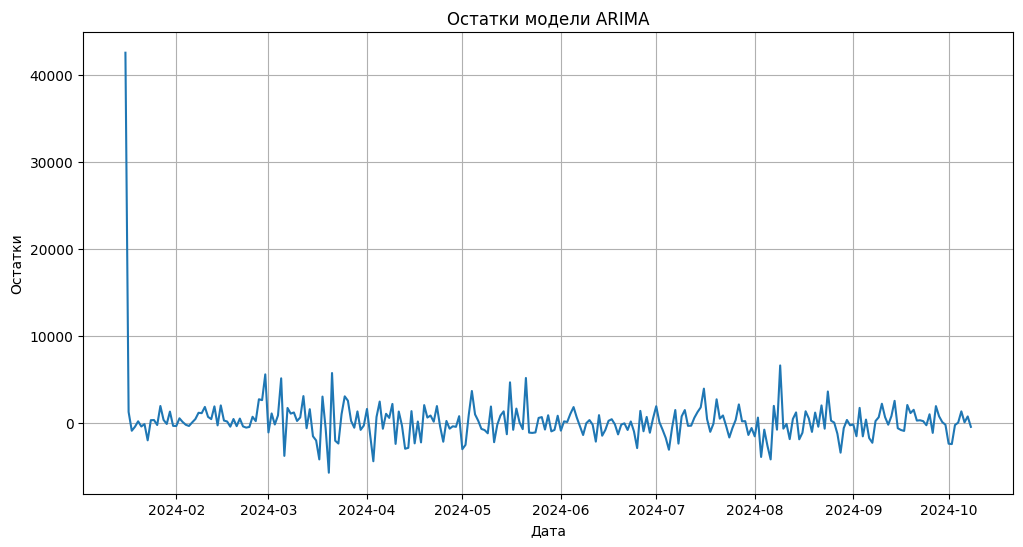

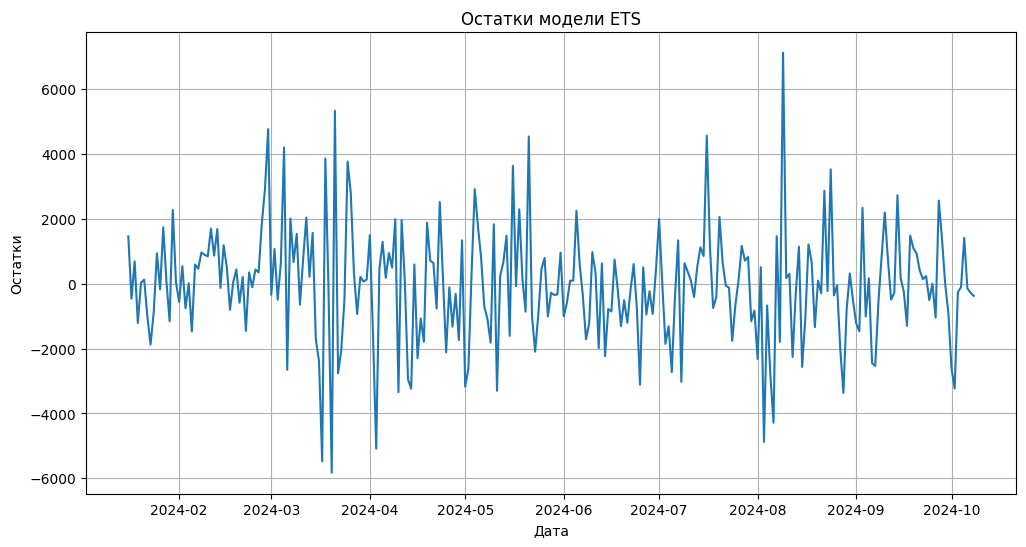

In [117]:
# Оценка остатков для ARIMA
arima_residuals = arima_fitted.resid
plt.figure(figsize=(12, 6))
plt.plot(arima_residuals)
plt.title('Остатки модели ARIMA')
plt.xlabel('Дата')
plt.ylabel('Остатки')
plt.grid(True)
plt.show()

# Оценка остатков для ETS
ets_residuals = ets_fitted.resid
plt.figure(figsize=(12, 6))
plt.plot(ets_residuals)
plt.title('Остатки модели ETS')
plt.xlabel('Дата')
plt.ylabel('Остатки')
plt.grid(True)
plt.show()

